# Figures for BSC

Brian requested the following for the BSC:

* heatmaps and clusters of scRNA.  
* X, Y 4th chromosome expression patterns.  

In [130]:
import os
import sys
import re
from pathlib import Path
from itertools import zip_longest
from yaml import load
from collections import defaultdict

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# Project level imports
from larval_gonad.notebook import Nb

In [131]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-02-20 
Git hash: 02e606676f937594e732e3c29cf439b65cd9c1bf


In [132]:
sns.set_context('poster')

In [133]:
clusters = (
    nbconfig.seurat.get_clusters('res.0.6')
    .map(nbconfig.short_cluster_annot)
    .pipe(lambda x: x[x != 'UNK'])
    .astype('category')
    .cat.as_ordered()
    .cat.reorder_categories(nbconfig.short_cluster_order)
    .to_frame()
    .assign(colors=lambda df: df.cluster.map(dict(zip(nbconfig.short_cluster_order, nbconfig.colors['clusters']))))
    .rename_axis('cell_id')
)

## TSNE

In [13]:
tsne = (
    nbconfig.seurat.get_tsne()
    .rename_axis('cell_id')
    .merge(clusters, on='cell_id')
)

In [14]:
def make_list(list_like):
    return np.array(
        list(
            zip_longest(list_like[:4], list_like[4:8], [list_like[-1]])
        )
    ).flatten().tolist()

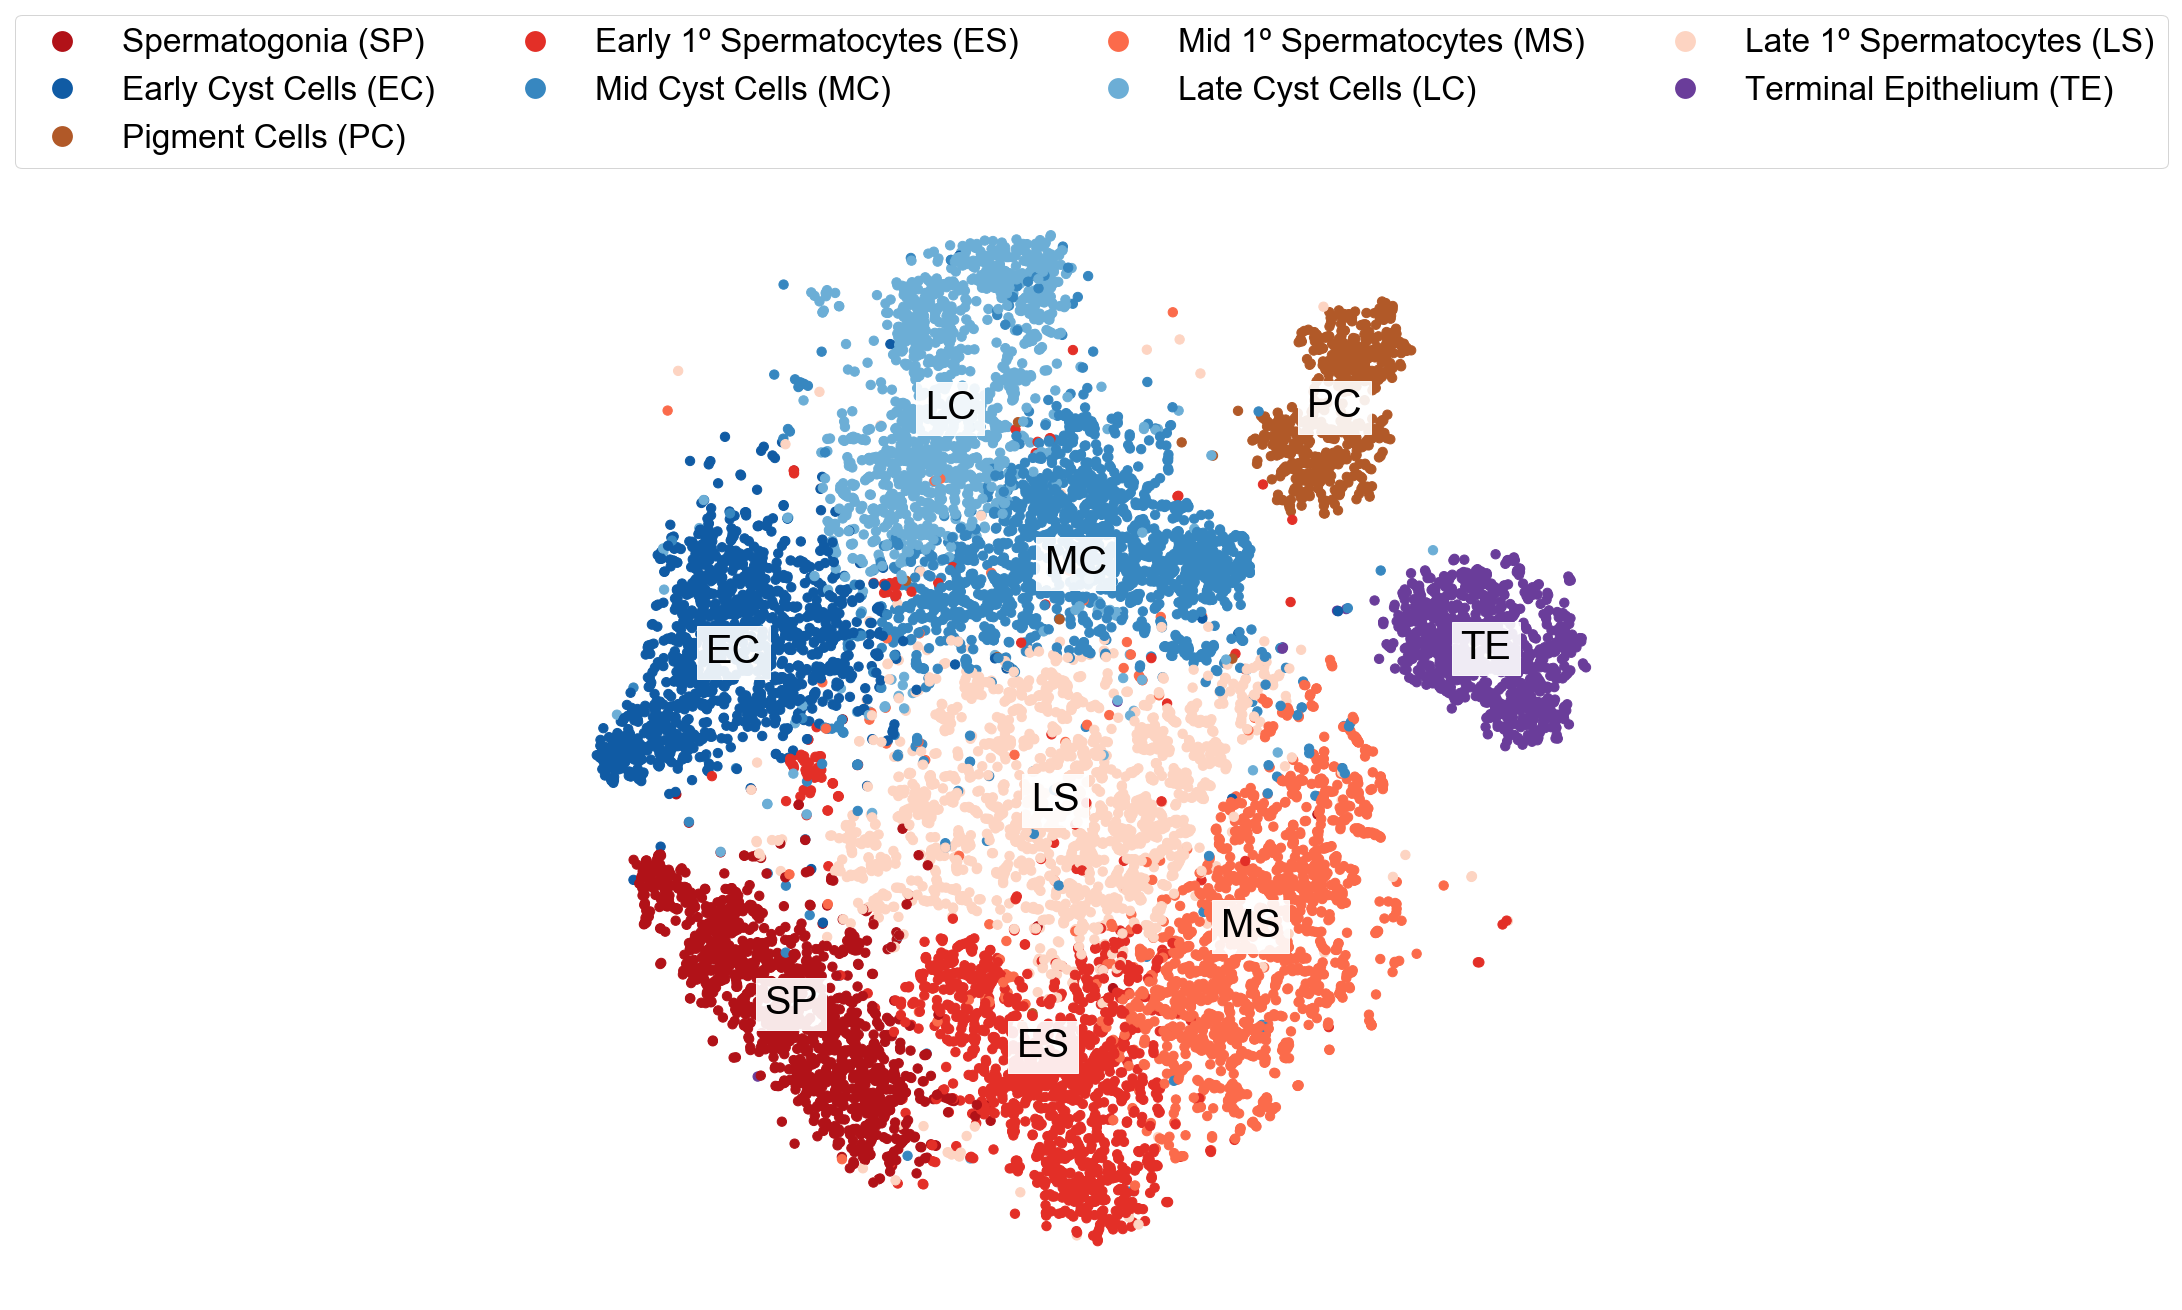

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne.tSNE_1, tsne.tSNE_2, s=20, c=tsne.colors)

# clean up axis
ax.set_aspect('equal')
sns.despine(fig=fig, left=True, bottom=True)
plt.setp(ax, yticks=[], xticks=[]);

# legend
legend_elements = [
    #Patch(facecolor=color, edgecolor='k', label=f'{lclus} ({sclus})')
    Line2D([0], [0], marker='o', color=(1, 1, 1, 0), markeredgecolor=color, markerfacecolor=color, markersize=10, label=f'{lclus} ({sclus})')
    for sclus, lclus, color in zip(make_list(nbconfig.short_cluster_order),  make_list(nbconfig.cluster_order[:9]), make_list(nbconfig.colors['clusters'][:9]))
    if sclus is not None
]

ax.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=[0.5, 1], facecolor=None)
for clus, row in tsne.groupby('cluster').agg({'tSNE_1': np.mean, 'tSNE_2': np.mean}).iterrows():
    plt.text(row.tSNE_1, row.tSNE_2, clus, backgroundcolor=(1, 1, 1, .9), ha='center', va='center')
plt.tight_layout()
plt.savefig('../output/notebook/2019-02-20_tsne.svg', bbox_inches='tight')
del tsne 
del legend_elements

## Lit Genes (Short)

In [87]:
zscores = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_zscore_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)

In [88]:
with open('../science_submission/config.yaml') as fh:
    lit_genes = load(fh.read())['lit_genes']

In [89]:
lit_fbgn = list(map(lambda x: nbconfig.symbol2fbgn[x], lit_genes))
lit_zscores = zscores.reindex(lit_fbgn).rename(index=nbconfig.fbgn2symbol)

In [90]:
long_to_short = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [91]:
def process_text(txt):
    match = re.match(f'(?P<type>.*?)-(?P<rep>rep\d)', txt)
    if match['rep'] == 'rep2':
        return long_to_short[match['type']]
    return ''

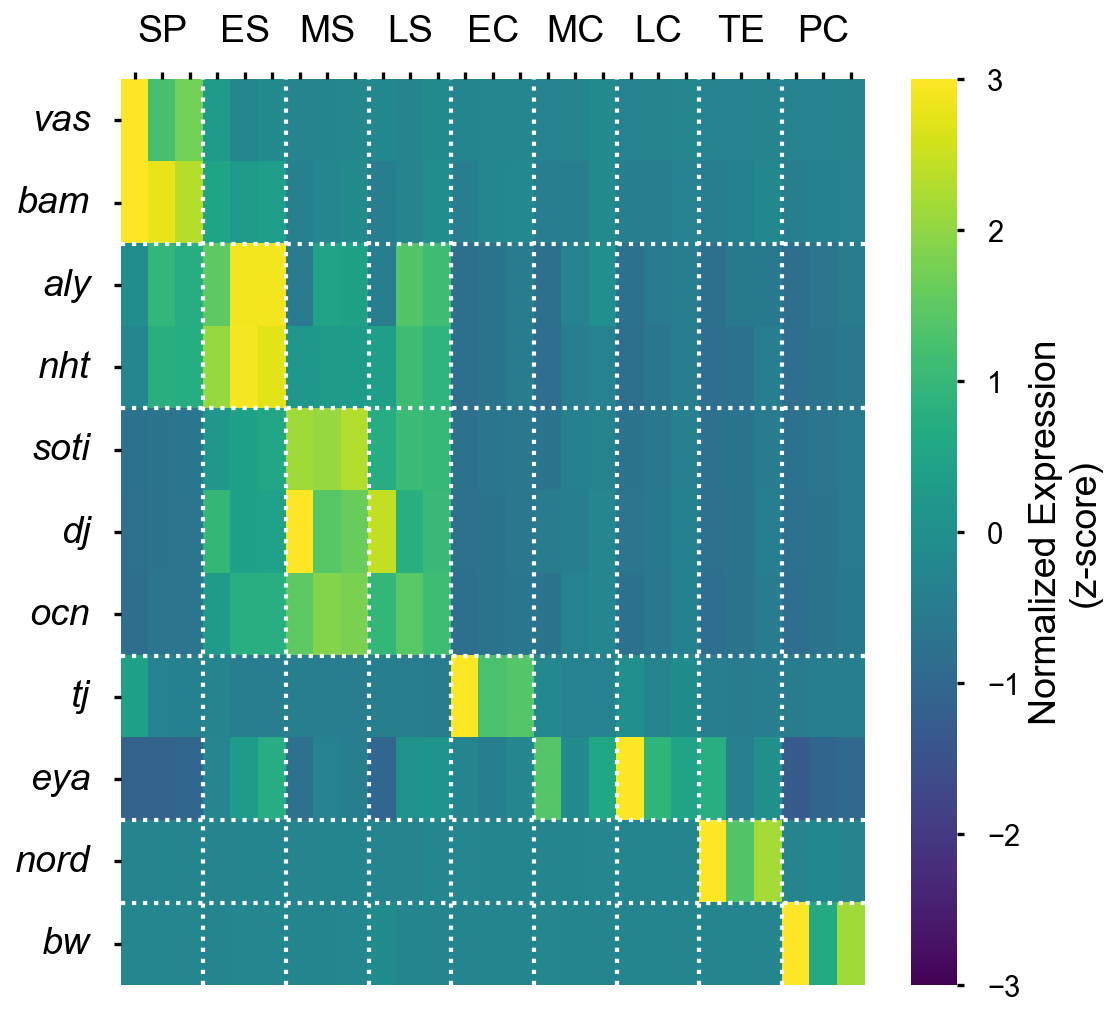

In [92]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(lit_zscores, cmap='viridis', yticklabels=True, xticklabels=True, vmin=-3, vmax=3, cbar_kws=dict(label='Normalized Expression\n(z-score)'), ax=ax, rasterized=True)

# fix up x-axis
labels = [
    process_text(l.get_text())
    for l in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=0, fontdict=dict(size=18), ha='center', va='bottom');
ax.set_xlabel('')
ax.xaxis.tick_top()

# fix up y-axis
labels = [
    l.get_text()
    for l in ax.get_yticklabels()
]
ax.set_yticklabels(labels, rotation=0, fontdict=dict(style='italic', size=18), va='center');
ax.set_ylabel('')

# Add cluster lines
loc = 3
for i in range(8):
    ax.axvline(loc, color='w', ls=':', lw=2)
    loc += 3
    
# Add cluster lines
ax.axhline(2, color='w', ls=':', lw=2)
ax.axhline(4, color='w', ls=':', lw=2)
ax.axhline(7, color='w', ls=':', lw=2)
ax.axhline(9, color='w', ls=':', lw=2)
ax.axhline(10, color='w', ls=':', lw=2)

# increase cbar axis
cbar = ax.collections[0].colorbar
label = cbar.ax.get_ylabel()
cbar.ax.set_ylabel(label, fontdict=dict(fontsize=18))
cbar.ax.tick_params(labelsize=14)

# save figure
plt.savefig('../output/notebook/2019-02-20_lit_genes.svg', bbox_inches='tight')
del zscores

## Lit Genes (full)

In [93]:
zscores = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_zscore_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)

In [94]:
# Genes commented out are not present int he zscores dataset
lit_genes = [
    #GSC, spermatogonia, early spermatocytes [:12] (12) (7)
    'vas',
    'bam',
    'Phf7',
    'CG11697',
    'p53',
    #'nos',
    #'bgcn',
    #'tut',
    'Rbp9',
    'peb',
    #'tej',
    #'Marf',
    # Later spermatocytes and spermatids [12:34] (22) (18)
    'aly',
    'nht',
    'soti',
    'dj',
    'ocn',
    'can',
    'fzo',
    'bol',
    #'mle',
    #'mia',
    'CG3927',
    'sunz',
    'sowi',
    'd-cup',
    'c-cup',
    'wa-cup',
    #'p-cup',
    #'r-cup',
    'oys',
    'topi',
    'sa',
    'CG8368',
    # Enriched in CySC lineage [34:58] (24) (18)
    'tj',
    #'eya',
    'zfh1',
    'vn',
    'foxo',
    #'apt',
    'ImpL2',
    'Wnt4',
    'Nrt',
    'bnb',
    #'neur',
    'robo2',
    'EcR',
    'gbb',
    'spict',
    'puc',
    #'sev',
    'hui',
    #'sano',
    'glob1',
    'Eip93F',
    'fax',
    'kek1',
    #'so',
    # Terminal epithelia [58:67] (9) (8)
    'nord',
    'retn',
    'abd-A',
    'Abd-B',
    'Wnt2',
    'Six4',
    #'CG18628',
    'MtnA',
    'N',
    # Pigment cells [67:] (4)
    'vkg',
    'Sox100B',
    'bw',
    'ems',
]

In [95]:
lit_fbgn = list(map(lambda x: nbconfig.symbol2fbgn[x], lit_genes))
lit_zscores = zscores.reindex(lit_fbgn).dropna().rename(index=nbconfig.fbgn2symbol)

In [96]:
long_to_short = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [97]:
def process_text(txt):
    match = re.match(f'(?P<type>.*?)-(?P<rep>rep\d)', txt)
    if match['rep'] == 'rep2':
        return long_to_short[match['type']]
    return ''

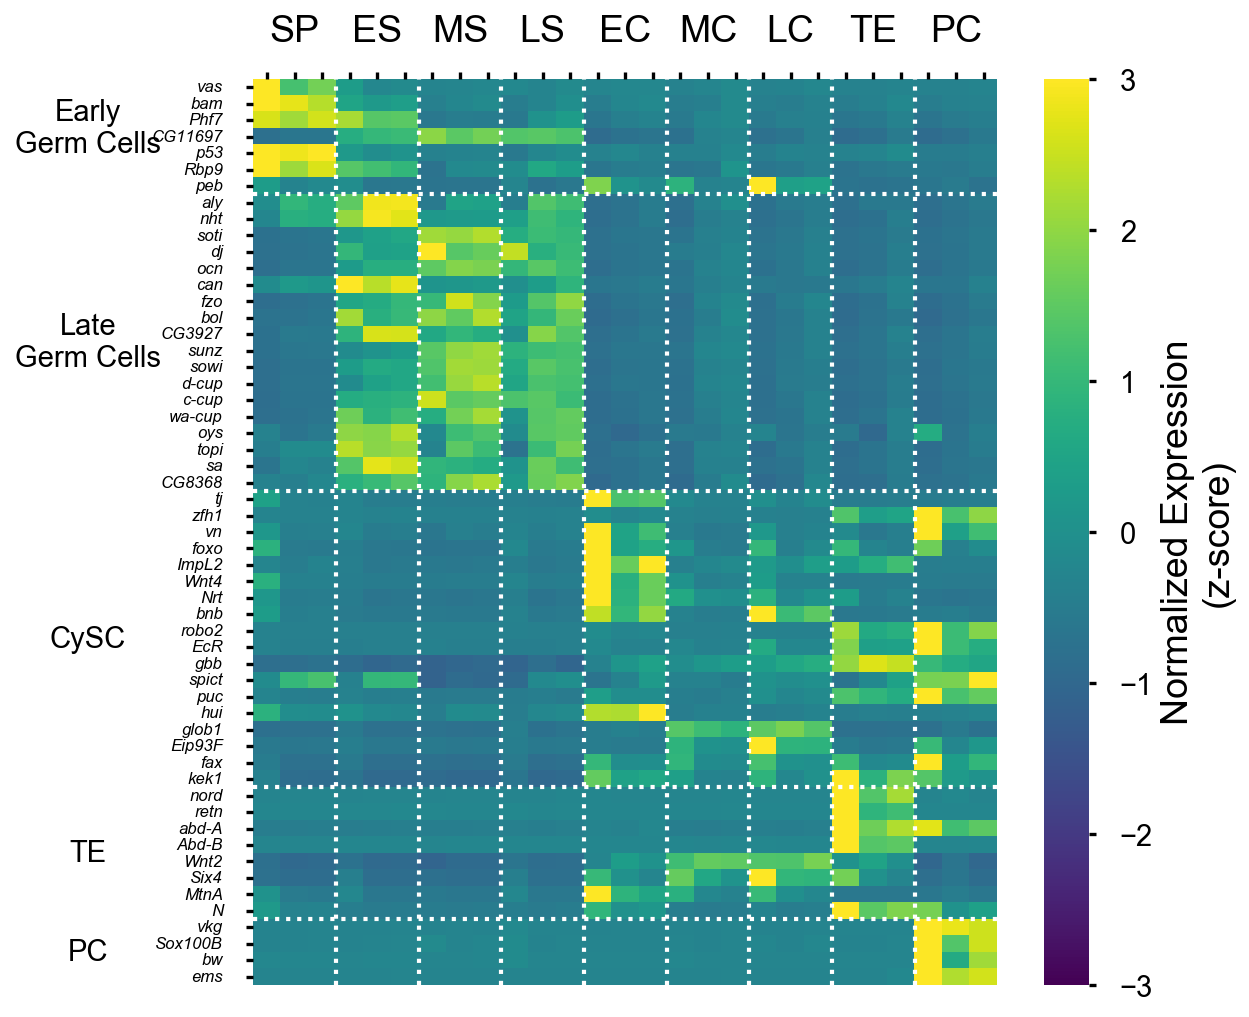

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(lit_zscores, cmap='viridis', yticklabels=True, xticklabels=True, vmin=-3, vmax=3, cbar_kws=dict(label='Normalized Expression\n(z-score)'), ax=ax, rasterized=True)

# fix up x-axis
labels = [
    process_text(l.get_text())
    for l in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=0, fontdict=dict(size=18), ha='center', va='bottom');
ax.set_xlabel('')
ax.xaxis.tick_top()

# fix up y-axis
labels = [
    l.get_text()
    for l in ax.get_yticklabels()
]
ax.set_yticklabels(labels, rotation=0, fontdict=dict(style='italic', size=8), va='center');
ax.set_ylabel('')

# Add cluster lines
loc = 3
for i in range(8):
    ax.axvline(loc, color='w', ls=':', lw=2)
    loc += 3
    
# Add cluster lines
previous = 0
for annot, loc in zip(['Early\nGerm Cells', 'Late\nGerm Cells', 'CySC', 'TE', 'PC'], np.cumsum([7, 18, 18, 8, 4])):
    if annot != 'PC':
        ax.axhline(loc, color='w', ls=':', lw=2)
    text_loc = loc - np.ceil((loc - previous) / 2)
    plt.text(-6, text_loc, annot, ha='center', va='center', fontsize=14, multialignment='center')
    previous = loc

# increase cbar axis
cbar = ax.collections[0].colorbar
label = cbar.ax.get_ylabel()
cbar.ax.set_ylabel(label, fontdict=dict(fontsize=18))
cbar.ax.tick_params(labelsize=14)

# save figure
plt.savefig('../output/notebook/2019-02-20_all_lit_genes.svg', bbox_inches='tight')
del zscores

## Unique BioMarkers

In [99]:
long_to_short = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [100]:
def process_text(txt):
    match = re.match(f'(?P<type>.*?)-(?P<rep>rep\d)', txt)
    if match['rep'] == 'rep2':
        return long_to_short[match['type']]
    return ''

In [101]:
zscores = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_zscore_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)

In [102]:
biomarkers = (
    nbconfig.seurat.get_biomarkers('res.0.6')
    .cluster.map(nbconfig.short_cluster_annot)
    .pipe(lambda x: x[x != "UNK"])
    .astype('category')
    .cat.as_ordered()
    .cat.reorder_categories(nbconfig.short_cluster_order)
)

unique_fbgns = (
    biomarkers
    .groupby('FBgn').size()
    .pipe(lambda x: x[x == 1])
    .index
)

In [103]:
biomarkers_by_cluster = biomarkers[biomarkers.index.isin(unique_fbgns)].sort_values()

In [104]:
zscores = zscores.reindex(biomarkers_by_cluster.index)

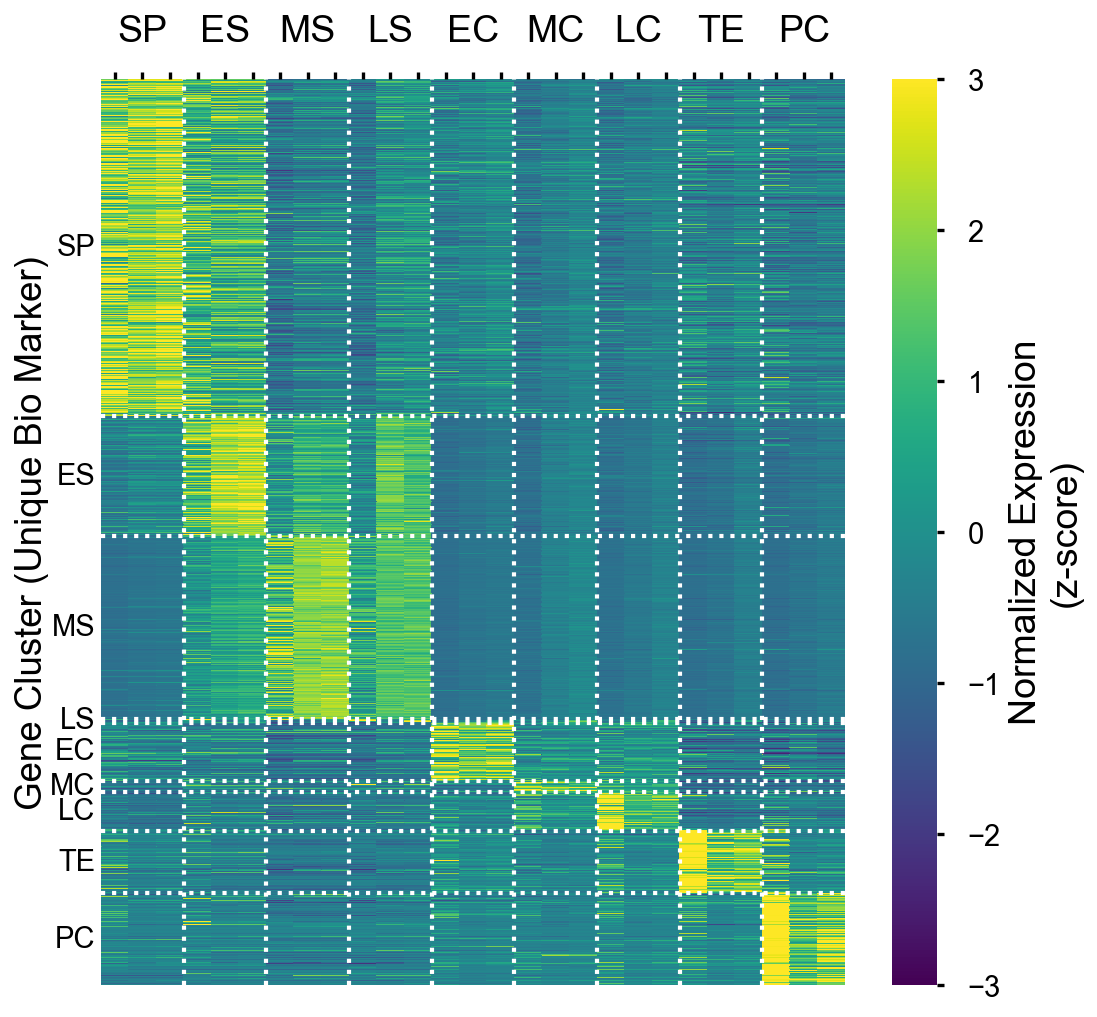

In [105]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(zscores, cmap='viridis', yticklabels=False, xticklabels=True, vmin=-3, vmax=3, cbar_kws=dict(label='Normalized Expression\n(z-score)'), ax=ax, rasterized=True)

# fix up x-axis
labels = [
    process_text(l.get_text())
    for l in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=0, fontdict=dict(size=18), ha='center', va='bottom');
ax.set_xlabel('')
ax.xaxis.tick_top()

# fix up y-axis
ax.set_ylabel('Gene Cluster (Unique Bio Marker)', labelpad=25)

# Add cluster lines
loc = 3
for i in range(8):
    ax.axvline(loc, color='w', ls=':', lw=2)
    loc += 3
    
# Add cluster lines
locs = biomarkers_by_cluster.value_counts().sort_index().values

previous = 0
for clus, loc in zip(nbconfig.short_cluster_order, np.cumsum(locs)):
    if clus != 'PC':
        ax.axhline(loc, color='w', ls=':', lw=2)
        
    text_loc = loc - np.ceil((loc - previous) / 2)
    plt.text(-.2, text_loc, clus, ha='right', va='center', fontsize=14)
    previous = loc

# increase cbar axis
cbar = ax.collections[0].colorbar
label = cbar.ax.get_ylabel()
cbar.ax.set_ylabel(label, fontdict=dict(fontsize=18))
cbar.ax.tick_params(labelsize=14)

# save figure
plt.savefig('../output/notebook/2019-02-20_unique_biomakrer_genes.svg', bbox_inches='tight')
del zscores
del biomarkers

## Non-unique BioMarkers

In [106]:
long_to_short = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [107]:
def process_text(txt):
    match = re.match(f'(?P<type>.*?)-(?P<rep>rep\d)', txt)
    if match['rep'] == 'rep2':
        return long_to_short[match['type']]
    return ''

In [108]:
zscores = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_zscore_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)

In [109]:
biomarkers = (
    nbconfig.seurat.get_biomarkers('res.0.6')
    .cluster.map(nbconfig.short_cluster_annot)
    .pipe(lambda x: x[x != "UNK"])
    .astype('category')
    .cat.as_ordered()
    .cat.reorder_categories(nbconfig.short_cluster_order)
)

mapper = {
    'SP': 'Germ',
    'ES': 'Germ',
    'MS': 'Germ',
    'LS': 'Germ',
    'EC': 'Soma',
    'MC': 'Soma',
    'LC': 'Soma',
    'TE': 'Soma',
    'PC': 'Soma',
}

multi_fbgns = (
    (biomarkers.map(mapper).groupby('FBgn').value_counts() > 0)
    .unstack()
    .fillna(False)
    .assign(germ_only = lambda df: df.Germ & ~df.Soma)
    .assign(soma_only = lambda df: ~df.Germ & df.Soma)
    .assign(germ_and_soma = lambda df: df.Germ & df.Soma)
    .drop(['Germ', 'Soma'], axis=1)
    .sort_values(by='soma_only', ascending=True)
    .sort_values(by='germ_and_soma', ascending=False)
    .sort_values(by='germ_only', ascending=False)
)

In [110]:
ordered_genes = []
for name, dd in multi_fbgns.idxmax(axis=1).rename('names').astype('category').cat.as_ordered().cat.reorder_categories(['germ_only', 'germ_and_soma', 'soma_only']).to_frame().groupby('names'):
    _curr = zscores.reindex(dd.index)
    tree = linkage(_curr, method='average')
    leaves = dendrogram(tree, no_plot=True)['leaves']
    ordered_genes.extend(_curr.index[leaves].tolist())

In [111]:
zscores = zscores.reindex(ordered_genes)

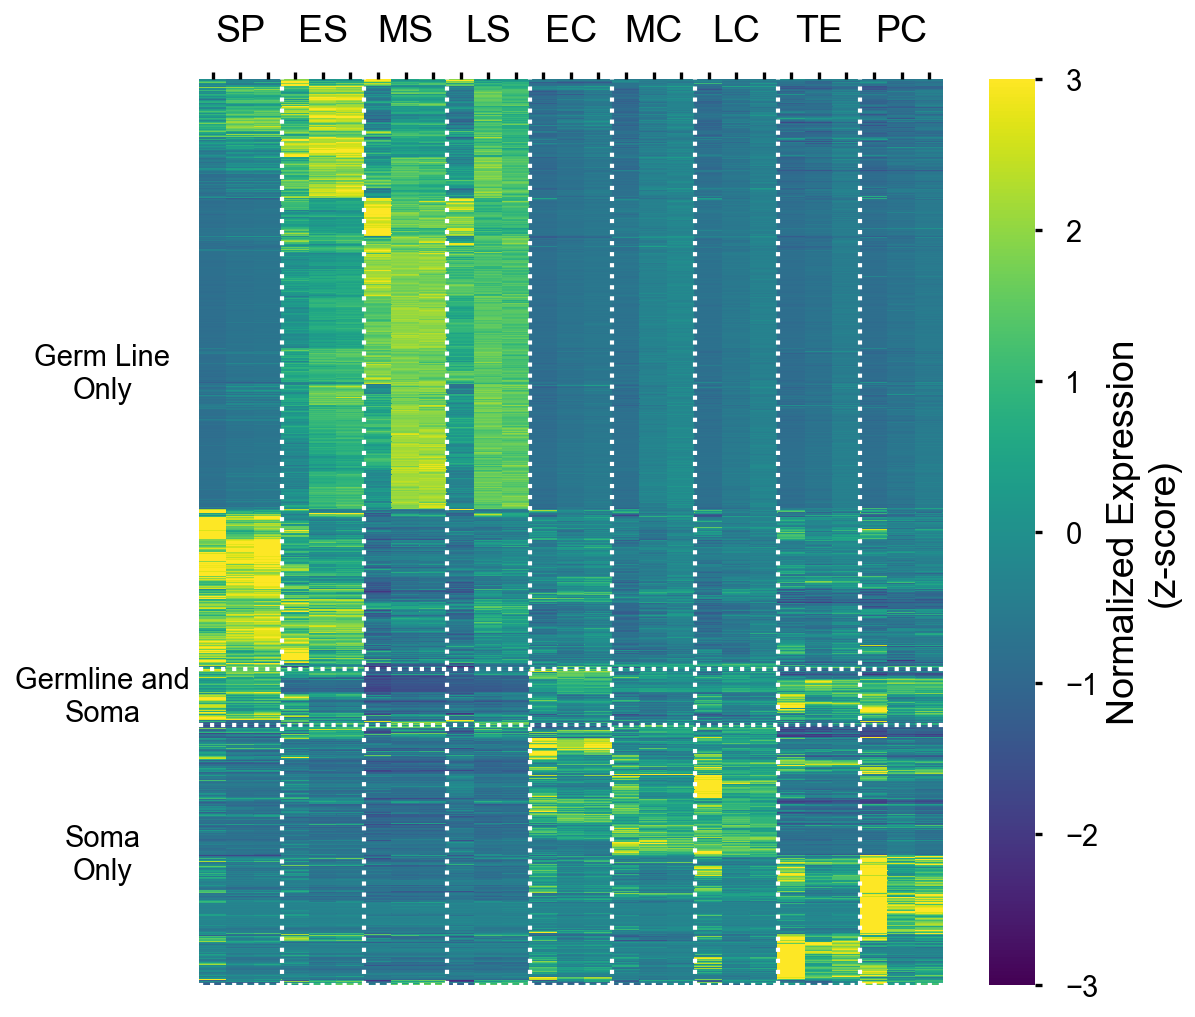

In [112]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(zscores, cmap='viridis', yticklabels=False, xticklabels=True, vmin=-3, vmax=3, cbar_kws=dict(label='Normalized Expression\n(z-score)'), ax=ax, rasterized=True)

# fix up x-axis
labels = [
    process_text(l.get_text())
    for l in ax.get_xticklabels()
]
ax.set_xticklabels(labels, rotation=0, fontdict=dict(size=18), ha='center', va='bottom');
ax.set_xlabel('')
ax.xaxis.tick_top()

# fix up y-axis
ax.set_ylabel('')

# Add cluster lines
loc = 3
for i in range(8):
    ax.axvline(loc, color='w', ls=':', lw=2)
    loc += 3
    
# Add cluster lines
locs = multi_fbgns.sum()[['germ_only', 'germ_and_soma', 'soma_only']].values

previous = 0
for clus, loc in zip(['Germ Line\nOnly', 'Germline and\nSoma', 'Soma\nOnly'], np.cumsum(locs)):
    if clus != 'soma_only':
        ax.axhline(loc, color='w', ls=':', lw=2)
        
    text_loc = loc - np.ceil((loc - previous) / 2)
    plt.text(-3.5, text_loc, clus, ha='center', va='center', fontsize=14, multialignment='center')
    previous = loc

# increase cbar axis
cbar = ax.collections[0].colorbar
label = cbar.ax.get_ylabel()
cbar.ax.set_ylabel(label, fontdict=dict(fontsize=18))
cbar.ax.tick_params(labelsize=14)

# save figure
plt.savefig('../output/notebook/2019-02-20_multi_biomakrer_genes.svg', bbox_inches='tight')
del zscores
del biomarkers

In [113]:
germ_and_soma = multi_fbgns[multi_fbgns.germ_and_soma].index.tolist()

## X Y 4th Expression by Rep

In [139]:
num_genes_per_chrom = nbconfig.fbgn2chrom.groupby('chrom').size()
num_genes_per_chrom

chrom
chr2L    3496
chr2R    3620
chr3L    3456
chr3R    4190
chr4      111
chrM       38
chrX     2669
chrY      113
dtype: int64

### TPM normalized by chrom by cluster

In [145]:
tpm = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)
num_genes_per_chrom = nbconfig.fbgn2chrom.groupby('chrom').size()

In [146]:
mapper = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [147]:
tpm_tidy = (
    tpm
    .merge(nbconfig.fbgn2chrom, on='FBgn')
    .reset_index()
    .melt(id_vars=['FBgn', 'chrom'], value_name='TPM', var_name='name')
    # split name up into cluster and replicate
    .assign(rep = lambda df: df.name.str.extract('(rep\d)').values)
    .assign(cluster = lambda df: df.name.str.extract('(?P<cluster>.*?)-rep\d').cluster.map(mapper).astype('category').cat.as_ordered().cat.reorder_categories(nbconfig.short_cluster_order))
    .drop('name', axis=1)
    # Sum gene counts to the chromosome arm level and normalize by the number of genes on that arm
    .groupby(['chrom', 'cluster', 'rep']).TPM.sum()
    .div(num_genes_per_chrom, level=0)
    # clean up 
    .to_frame()
    .reset_index()
    .rename({0: 'TPM'}, axis=1)
    # Remove chr fo nicer plotting
    .assign(chrom = lambda df: df.chrom.str.extract('chr(.*)').values)
)

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


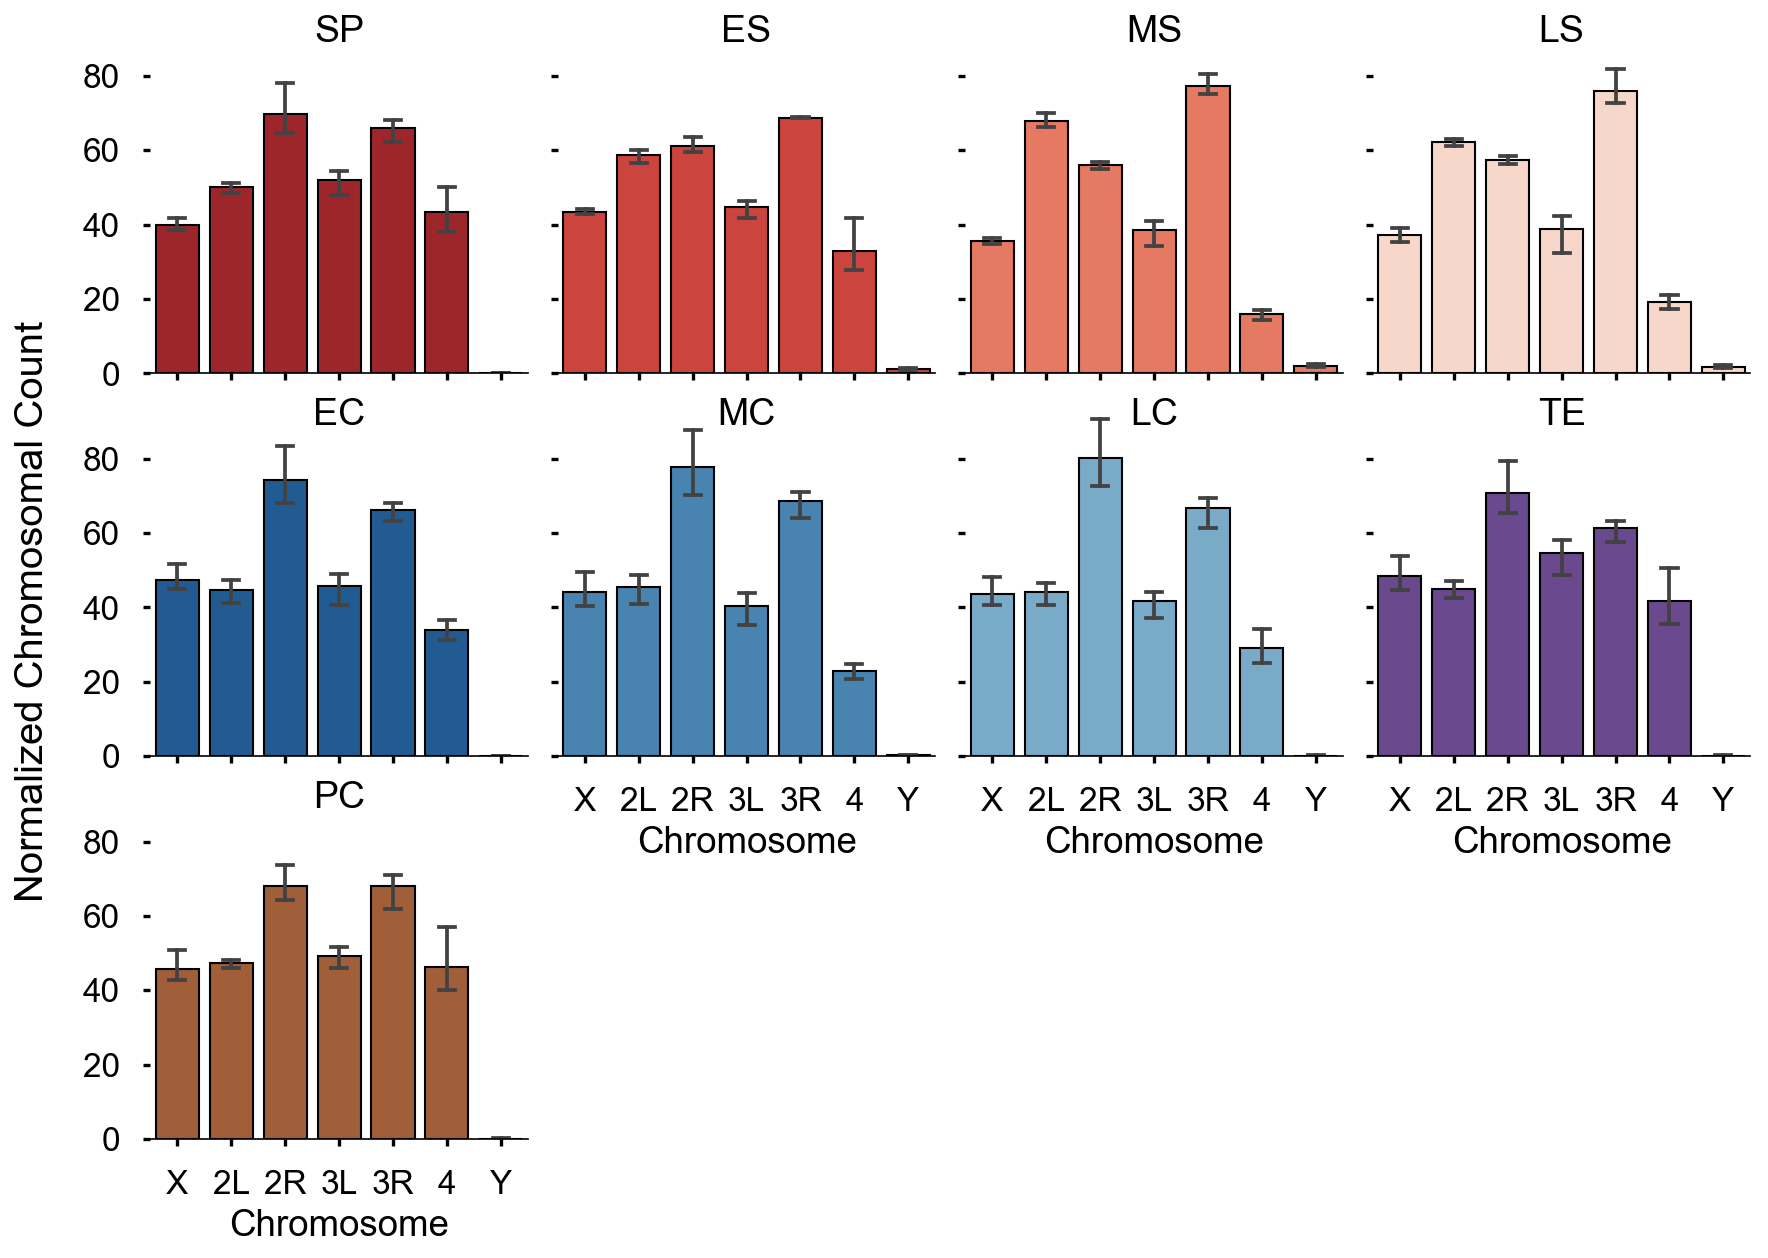

In [148]:
g = (
    sns.FacetGrid(tpm_tidy, col='cluster', col_order=nbconfig.short_cluster_order, col_wrap=4, hue='cluster', palette=nbconfig.colors['clusters'])
    .map(sns.barplot, 'chrom', 'TPM', order=[x.lstrip('chr') for x in nbconfig.chrom_order], errwidth=1.8, capsize=.3, linewidth=1, edgecolor='k')
    .set_titles('{col_name}', size=18, y=.9)
    .set_ylabels('')
    .set_xlabels('Chromosome')
    .despine(left=True)
)
plt.text(0.03, 0.5, 'Normalized Chromosomal Count', rotation=90, ha='right', va='center', transform=g.fig.transFigure)
plt.subplots_adjust(hspace=0.08, wspace=0.08)
g.fig.savefig('../output/notebook/2019-02-20_bar_plot_tpm_expression_by_arm.svg', bbox_inches='tight')
del tpm
del tpm_tidy

### Log TPM normalized by chrom by cluster

In [149]:
tpm = (
    pd.read_parquet('../output/scrnaseq-wf/tpm_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)
num_genes_per_chrom = nbconfig.fbgn2chrom.groupby('chrom').size()

In [150]:
mapper = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [151]:
tpm_tidy = (
    tpm
    .merge(nbconfig.fbgn2chrom, on='FBgn')
    .reset_index()
    .melt(id_vars=['FBgn', 'chrom'], value_name='TPM', var_name='name')
    # split name up into cluster and replicate
    .assign(rep = lambda df: df.name.str.extract('(rep\d)').values)
    .assign(cluster = lambda df: df.name.str.extract('(?P<cluster>.*?)-rep\d').cluster.map(mapper).astype('category').cat.as_ordered().cat.reorder_categories(nbconfig.short_cluster_order))
    .drop('name', axis=1)
    # Sum gene counts to the chromosome arm level and normalize by the number of genes on that arm
    .groupby(['chrom', 'cluster', 'rep']).TPM.sum()
    .div(num_genes_per_chrom, level=0)
    # clean up 
    .to_frame()
    .reset_index()
    .rename({0: 'TPM'}, axis=1)
    # Remove chr fo nicer plotting
    .assign(chrom = lambda df: df.chrom.str.extract('chr(.*)').values)
    .assign(log_TPM = lambda df: np.log2(df.TPM + .7))
)

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


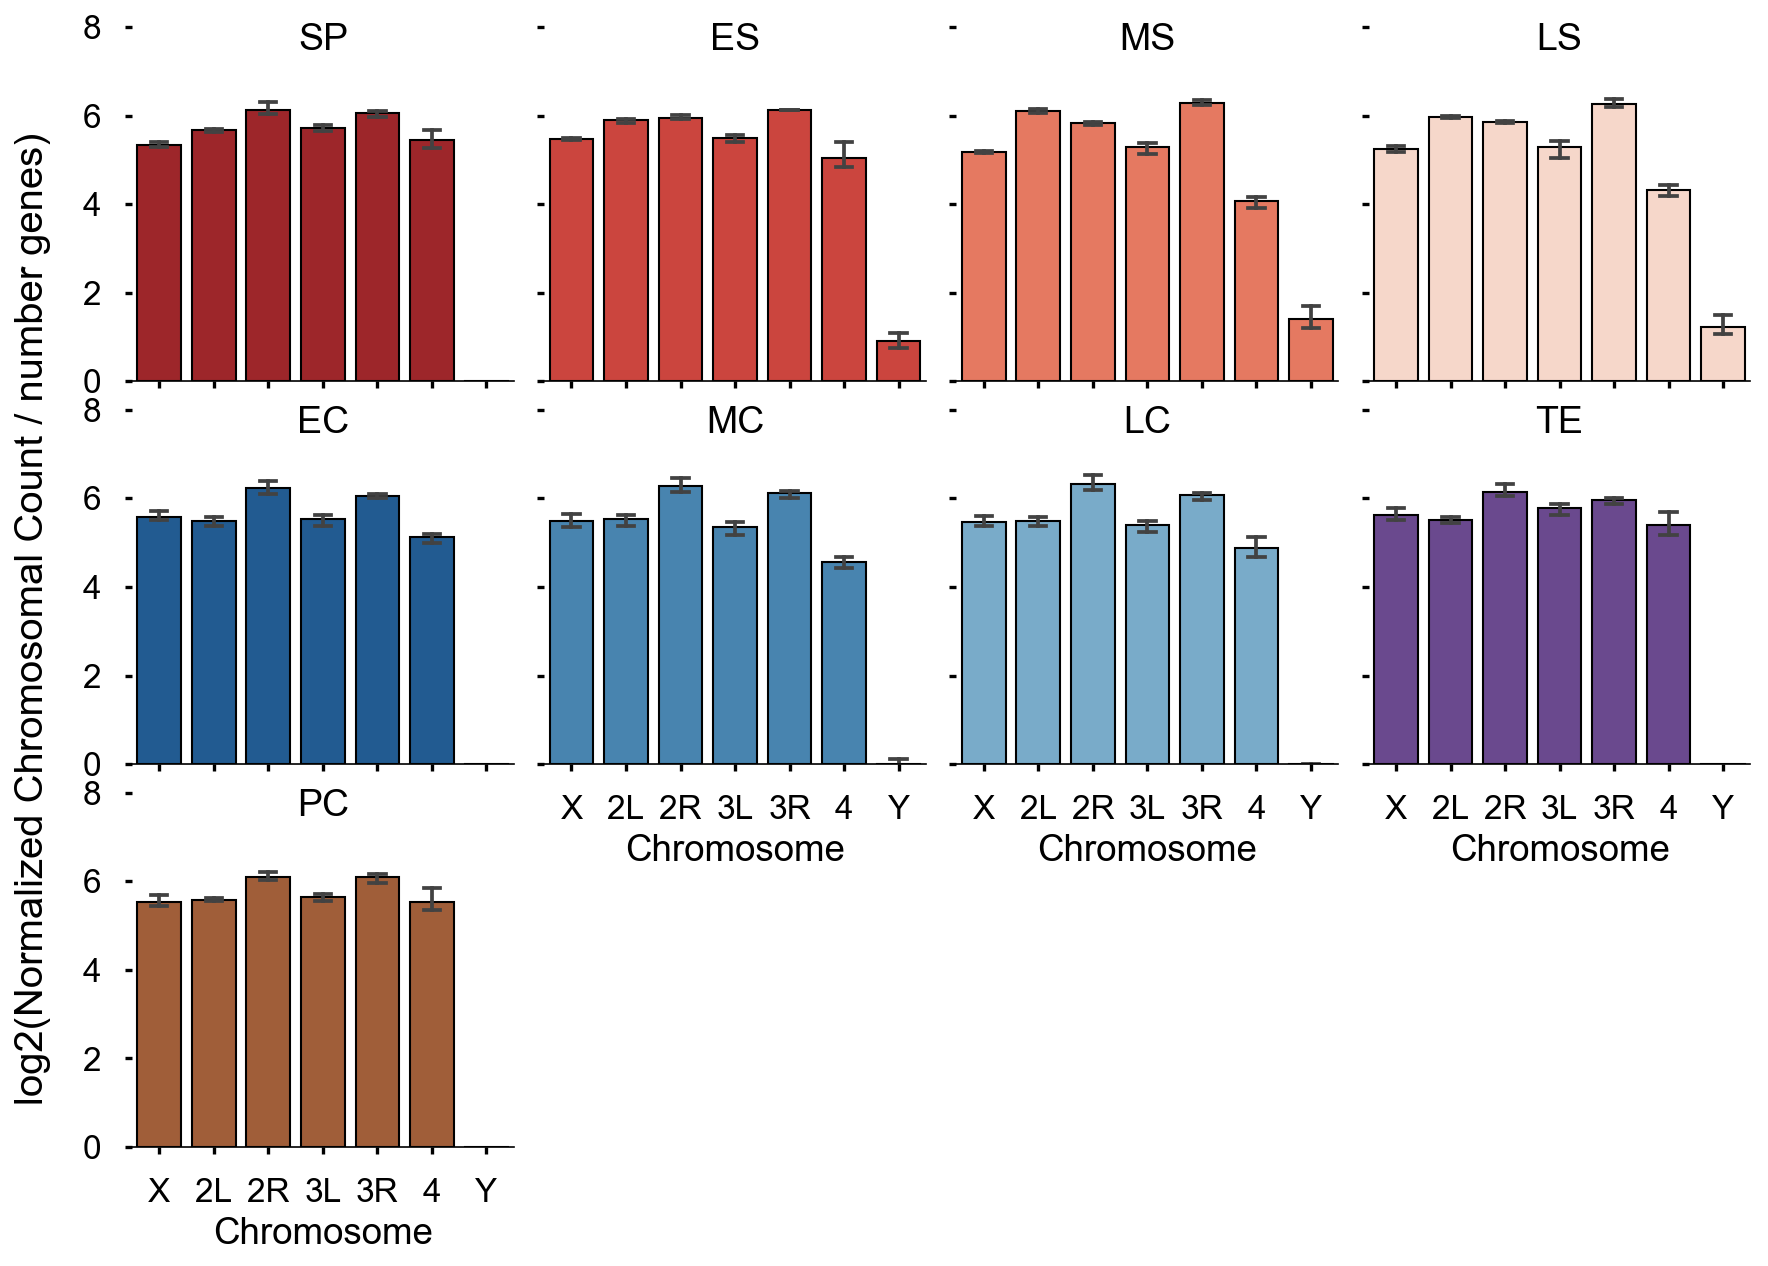

In [152]:
g = (
    sns.FacetGrid(tpm_tidy, col='cluster', col_order=nbconfig.short_cluster_order, col_wrap=4, hue='cluster', palette=nbconfig.colors['clusters'], ylim=(0, 8))
    .map(sns.barplot, 'chrom', 'log_TPM', order=[x.lstrip('chr') for x in nbconfig.chrom_order], errwidth=1.8, capsize=.3, linewidth=1, edgecolor='k')
    .set_titles('{col_name}', size=18, y=.9)
    .set_ylabels('')
    .set_xlabels('Chromosome')
    .despine(left=True)
)
plt.text(0.03, 0.5, 'log2(Normalized Chromosomal Count / number genes)', rotation=90, ha='right', va='center', transform=g.fig.transFigure)
plt.subplots_adjust(hspace=0.08, wspace=0.08)
g.fig.savefig('../output/notebook/2019-02-20_bar_plot_log2_tpm_expression_by_arm.svg', bbox_inches='tight')
del tpm
del tpm_tidy

### Proportion of genes on

In [153]:
raw = (
    pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster_w_rep.parquet')
    .loc[:, nbconfig.sel_cluster_order_w_rep]
)
num_genes_per_chrom = nbconfig.fbgn2chrom.groupby('chrom').size()

In [154]:
mapper = dict(zip(nbconfig.sel_cluster_order, nbconfig.short_cluster_order))

In [155]:
prop_tidy = (
    (raw > 5)
    .merge(nbconfig.fbgn2chrom, on='FBgn')
    .reset_index()
    .melt(id_vars=['FBgn', 'chrom'], value_name='flag_on', var_name='name')
    # split name up into cluster and replicate
    .assign(rep = lambda df: df.name.str.extract('(rep\d)').values)
    .assign(cluster = lambda df: df.name.str.extract('(?P<cluster>.*?)-rep\d').cluster.map(mapper).astype('category').cat.as_ordered().cat.reorder_categories(nbconfig.short_cluster_order))
    .drop('name', axis=1)
    # Sum gene counts to the chromosome arm level and normalize by the number of genes on that arm
    .groupby(['chrom', 'cluster', 'rep']).flag_on.sum()
    .div(num_genes_per_chrom, level=0)
    .mul(100)
    # clean up 
    .to_frame()
    .reset_index()
    .rename({0: 'Percent On'}, axis=1)
    # Remove chr fo nicer plotting
    .assign(chrom = lambda df: df.chrom.str.extract('chr(.*)').values)
)

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


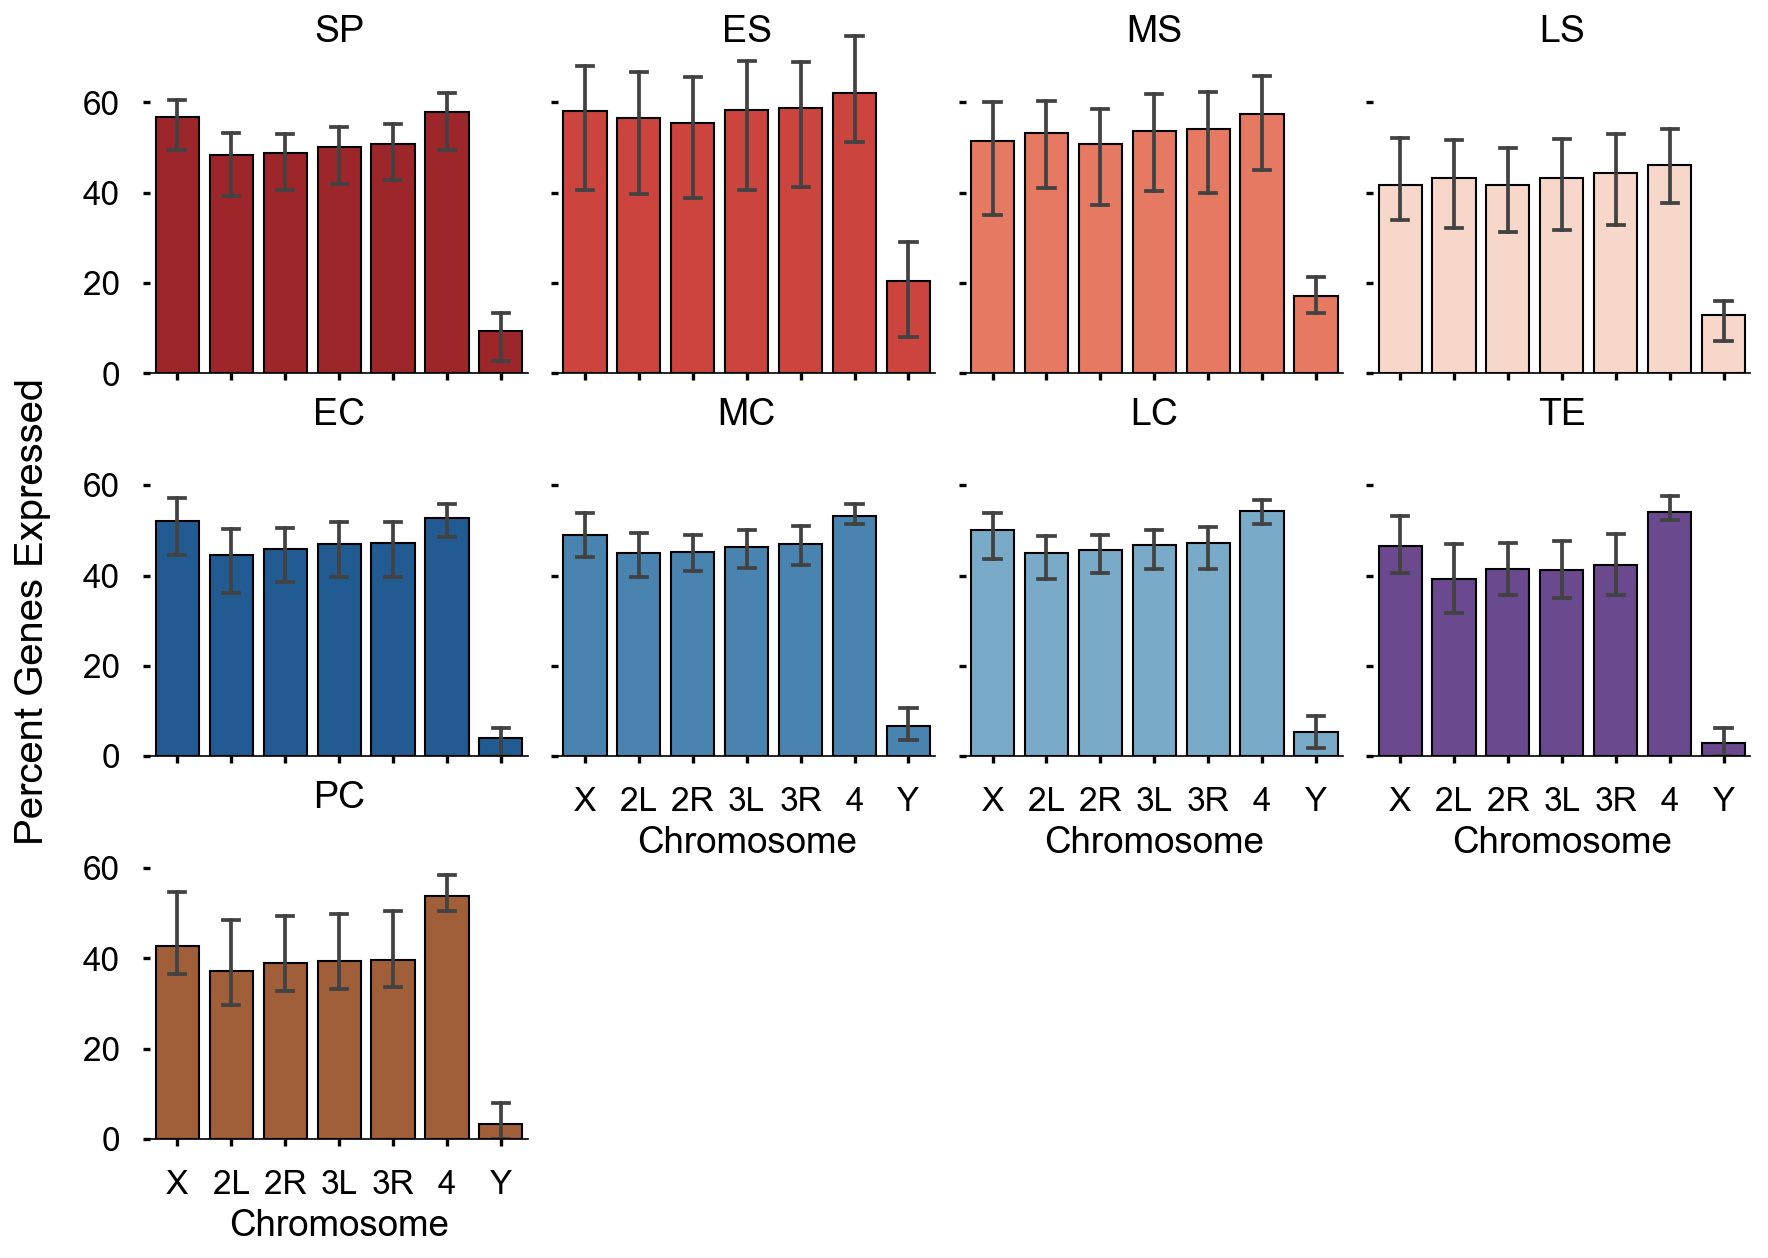

In [156]:
g = (
    sns.FacetGrid(prop_tidy, col='cluster', col_order=nbconfig.short_cluster_order, col_wrap=4, hue='cluster', palette=nbconfig.colors['clusters'])
    .map(sns.barplot, 'chrom', 'Percent On', order=[x.lstrip('chr') for x in nbconfig.chrom_order], errwidth=1.8, capsize=.3, linewidth=1, edgecolor='k')
    .set_titles('{col_name}', size=18, y=.9)
    .set_ylabels('')
    .set_xlabels('Chromosome')
    .despine(left=True)
)
plt.text(0.03, 0.5, 'Percent Genes Expressed', rotation=90, ha='right', va='center', transform=g.fig.transFigure)
plt.subplots_adjust(hspace=0.08, wspace=0.08)
g.fig.savefig('../output/notebook/2019-02-20_bar_plot_percent_expressed_by_arm.svg', bbox_inches='tight')
del raw
del prop_tidy

## X Y 4th to Autosome Ratios

In [73]:
mapper = {'chrX': 'X', 'chrY': 'Y', 'chr4': '4', 'chr2L': 'A','chr2R': 'A','chr3L': 'A','chr3R': 'A',}
fbgn2chrom = (
    pd.read_csv('../output/fbgn2chrom.tsv', sep='\t', index_col=0)
    .chrom.map(mapper)
    .dropna()
)

num_genes_per_chrom = fbgn2chrom.value_counts()
num_genes_per_chrom

A    14762
X     2669
Y      113
4      111
Name: chrom, dtype: int64

In [74]:
raw_tidy = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet', columns=clusters.index)
    .join(fbgn2chrom, on='FBgn')
    .reset_index()
    .melt(id_vars=['FBgn', 'chrom'], value_name='UMI', var_name='cell_id')
    .join(clusters, on='cell_id')
    .drop('colors', axis=1)
)

In [75]:
ratios_by_cell = (
    raw_tidy.groupby(['cell_id', 'cluster', 'chrom'])
    .UMI.sum()
    .div(num_genes_per_chrom / 1e3, level='chrom')
    .unstack()
    .assign(ratio_x = lambda df: df.X / df.A)
    .assign(ratio_y = lambda df: df.Y / df.A)
    .assign(ratio_4 = lambda df: df['4'] / df.A)
    .drop(['X', 'Y', 'A', '4'], axis=1)
    .reset_index('cluster')
)

In [76]:
median_ratios = ratios_by_cell.groupby('cluster').median().reindex(nbconfig.short_cluster_order) + 0.0001

In [77]:
median_ratios

chrom,ratio_x,ratio_y,ratio_4
cluster,,,
SP,0.811057,0.000100,1.239405
ES,0.726484,0.043528,0.635127
MS,0.596505,0.048466,0.417654
LS,0.645726,0.000100,0.491270
EC,1.020210,0.000100,1.278177
MC,0.957064,0.000100,0.797353
LC,0.944277,0.000100,0.916470
TE,1.035448,0.000100,1.300799
PC,1.087713,0.000100,1.374337


In [78]:
pd.concat([
    (median_ratios.loc['SP'] / median_ratios.loc['ES']).rename('SP/ES'), 
    (median_ratios.loc['SP'] / median_ratios.loc['MS']).rename('SP/MS'),
    (median_ratios.loc['SP'] / median_ratios.loc['LS']).rename('SP/LS')
], axis=1, sort=True)

,SP/ES,SP/MS,SP/LS
chrom,,,
ratio_4,1.951428,2.967540,2.522862
ratio_x,1.116415,1.359681,1.256040
ratio_y,0.002297,0.002063,1.000000


In [79]:
1 / median_ratios

chrom,ratio_x,ratio_y,ratio_4
cluster,,,
SP,1.232959,10000.000000,0.806839
ES,1.376494,22.973523,1.574488
MS,1.676431,20.632926,2.394326
LS,1.548645,10000.000000,2.035542
EC,0.980190,10000.000000,0.782364
MC,1.044862,10000.000000,1.254150
LC,1.059012,10000.000000,1.091143
TE,0.965765,10000.000000,0.768759
PC,0.919360,10000.000000,0.727624


In [80]:
cutoff = 0.05

results = []
permuted_ratios_by_cell = ratios_by_cell.copy()
for iteration in range(10_000):
    permuted_ratios_by_cell.cluster = permuted_ratios_by_cell.cluster.sample(frac=1).values
    for clus, observed_ratios in ratios_by_cell.groupby('cluster'):
        permuted_ratios = permuted_ratios_by_cell.query(f'cluster == "{clus}"')
        _, pval_x = mannwhitneyu(observed_ratios.ratio_x, permuted_ratios.ratio_x, alternative='less')
        _, pval_y = mannwhitneyu(observed_ratios.ratio_y, permuted_ratios.ratio_y, alternative='greater')
        _, pval_4 = mannwhitneyu(observed_ratios.ratio_4, permuted_ratios.ratio_4, alternative='less')
        results.append((clus, pval_x <= cutoff, pval_y <= cutoff, pval_4 <= cutoff))

In [81]:
pvals = 1 - (
    pd.DataFrame(results, columns=['cluster', 'sig_x', 'sig_y', 'sig_4']).groupby('cluster')
    .mean()
    .rename(columns=dict(sig_x='pval_x_lt_a', sig_y='pval_y_gt_a', sig_4='pval_4_lt_a'))
    .loc[nbconfig.short_cluster_order, :]
)
pvals

,pval_x_lt_a,pval_y_gt_a,pval_4_lt_a
cluster,,,
SP,0.9064,1.0,1.0000
ES,0.0000,0.0,0.0000
MS,0.0000,0.0,0.0000
LS,0.0000,0.0,0.0000
EC,1.0000,1.0,1.0000
MC,1.0000,1.0,0.0629
LC,1.0000,1.0,1.0000
TE,1.0000,1.0,1.0000
PC,1.0000,1.0,1.0000


In [82]:
def whisker(dat):
    low, high = np.percentile(dat, [25, 75])
    iqr = high - low
    return high + (1.5 * iqr)

In [83]:
def plot_pval(dat, pvals, ax):
    whiskers = (
        dat.groupby('cluster')
        .apply(whisker)
        .to_dict()
    )
    
    for i, clus in enumerate(nbconfig.short_cluster_order):
        pval = pvals.loc[clus]
        loc = whiskers[clus]
        
        if pval <= 0.001:
            ax.text(i, loc, '***', ha='center', va='bottom')
        elif pval <= 0.01:
            ax.text(i, loc, '**', ha='center', va='bottom')
        elif pval <= 0.05:
            ax.text(i, loc, '*', ha='center', va='bottom')

In [84]:
ratios_by_cell.head()

chrom,cluster,ratio_x,ratio_y,ratio_4
cell_id,,,,
rep1_AAACCTGAGACAAGCC,MC,0.927737,0.000000,0.106734
rep1_AAACCTGAGCTTATCG,MC,1.409952,0.000000,0.964701
rep1_AAACCTGGTGTAATGA,EC,1.147458,0.000000,1.984940
rep1_AAACCTGGTTCATGGT,MS,0.537105,0.046048,0.492212
rep1_AAACCTGTCCCTCTTT,MC,1.093753,0.000000,1.195425


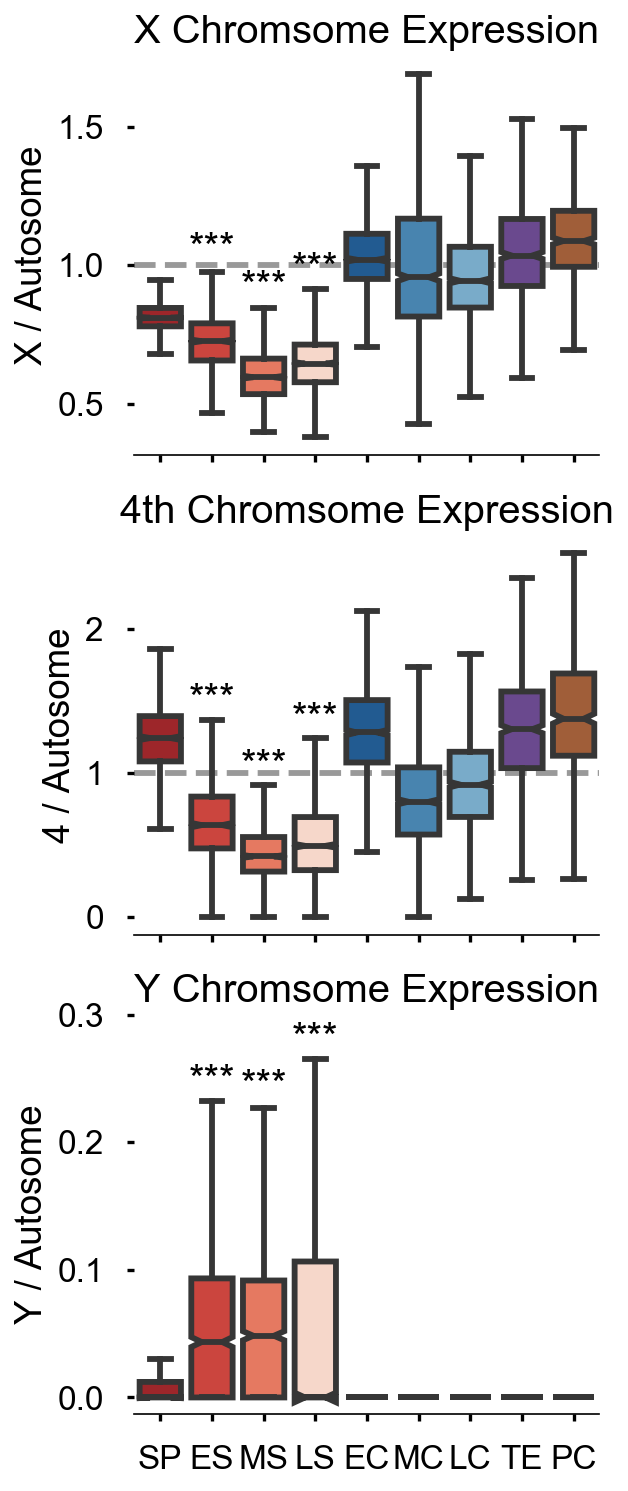

In [157]:
fig, axes = plt.subplots(3, 1, figsize=plt.figaspect(3), sharex=True, gridspec_kw=dict(hspace=.2))

_defaults = dict(x='cluster', data=ratios_by_cell, order=nbconfig.short_cluster_order, showfliers=False, palette=nbconfig.colors['clusters'], notch=True)

ax = axes[0]
sns.boxplot(y='ratio_x', ax=ax, **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_x']], pvals.pval_x_lt_a, ax)
sns.despine(ax=ax, left=True)
ax.set_title('X Chromsome Expression')
ax.set_xlabel('')
ax.set_ylabel('X / Autosome')
ax.axhline(1, color='gray', ls='--', zorder=0, alpha=.8, label='Median A')

ax = axes[1]
sns.boxplot(y='ratio_4', ax=ax, **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_4']], pvals.pval_4_lt_a, ax)
sns.despine(ax=ax, left=True)
ax.set_title('4th Chromsome Expression')
ax.set_xlabel('')
ax.set_ylabel('4 / Autosome')
ax.axhline(1, color='gray', ls='--', zorder=0, alpha=.8, label='Median A')

ax = axes[2]
sns.boxplot(y='ratio_y', ax=ax, **_defaults)
plot_pval(ratios_by_cell[['cluster', 'ratio_y']], pvals.pval_y_gt_a, ax)
sns.despine(ax=ax, left=True)
ax.set_title('Y Chromsome Expression')
ax.set_xlabel('')
ax.set_ylabel('Y / Autosome')
ax.set_ylim(None, .3)

fig.savefig('../output/notebook/2019-02-20_boxplot_autosome_ratios.svg', bbox_inches='tight')

In [158]:
del raw_tidy

NameError: name 'raw_tidy' is not defined

In [160]:
del ratios_by_cell

NameError: name 'ratios_by_cell' is not defined